In [13]:
# from sim_bfr_240611.config import RAW_DATA_DIR
RAW_DATA_DIR = 'Greg_simulation'
import scipp as sc
import plopp as pp
import scippneutron as scn
import scippnexus as snx
import numpy as np
from easyscience.Objects.new_variable import Parameter
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [14]:
def find_threshold_crossing(data, x=None, threshold_fraction=0.5):
    """
    Find the x-values where the data crosses a specified threshold of the peak value,
    taking into account the cyclic nature of the data.

    Parameters:
    - data (numpy array): The data containing the peak.
    - x (numpy array): The x-axis values corresponding to the data points. If None, indices will be used.
    - threshold_fraction (float): The fraction of the peak value to find the crossing at.

    Returns:
    - left_x (float): The x-value of the crossing point to the left of the peak.
    - right_x (float): The x-value of the crossing point to the right of the peak.
    - peak_x (float): The x-value of the peak.
    - width (float): The calculated width of the peak considering the cyclic nature.
    """

    if x is None:
        x = np.arange(len(data))  # Use indices if x is not provided

    # Ensure x is a numpy array
    x = np.asarray(x)

    # Find the maximum value and its index
    max_value = np.max(data)
    max_index = np.argmax(data)
    peak_x = x[max_index]

    # Calculate the threshold value
    threshold_value = max_value * threshold_fraction

    # Find left crossing
    left_x = None
    for i in range(max_index, max_index - len(data), -1):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == 0:
                interp_left = np.interp(threshold_value, [data[-1], data[0]], [x[-1] - x[-1] + x[0], x[0]])
            else:
                interp_left = np.interp(threshold_value, [data[idx-1], data[idx]], [x[idx-1], x[idx]])
            left_x = interp_left
            break

    # Find right crossing
    right_x = None
    for i in range(max_index, max_index + len(data)):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == len(data) - 1:
                interp_right = np.interp(threshold_value, [data[idx], data[0]], [x[idx], x[0] + x[-1] - x[0]])
            else:
                interp_right = np.interp(threshold_value, [data[idx], data[idx+1]], [x[idx], x[idx+1]])
            right_x = interp_right
            break

    # Calculate the width considering wrapping
    if right_x is not None and left_x is not None:
        width = right_x - left_x
        if width < 0:
            width += (x[-1] - x[0])
    else:
        width = None  # Handle cases where crossings couldn't be found

    return left_x, right_x, peak_x, width

In [15]:
filename=RAW_DATA_DIR +"/BIFROST_20240610T151842.h5"
dg = snx.File(filename)

In [16]:
example_data=dg['/entry/instrument/110_frame_3']['data']['time',1]
# example_data=dg['/entry/instrument/090_frame_1']['data']['time',1]
# example_data=dg['/entry/instrument/007_frame_0']['data']['time',1]

example_data.coords['t']=sc.midpoints(example_data.coords['t']) # convert from bin edges to bin centers


FWHM : 68599.74455445545
Left Crossing : 20509.201980198024
Right Crossing : 17680.34653465347


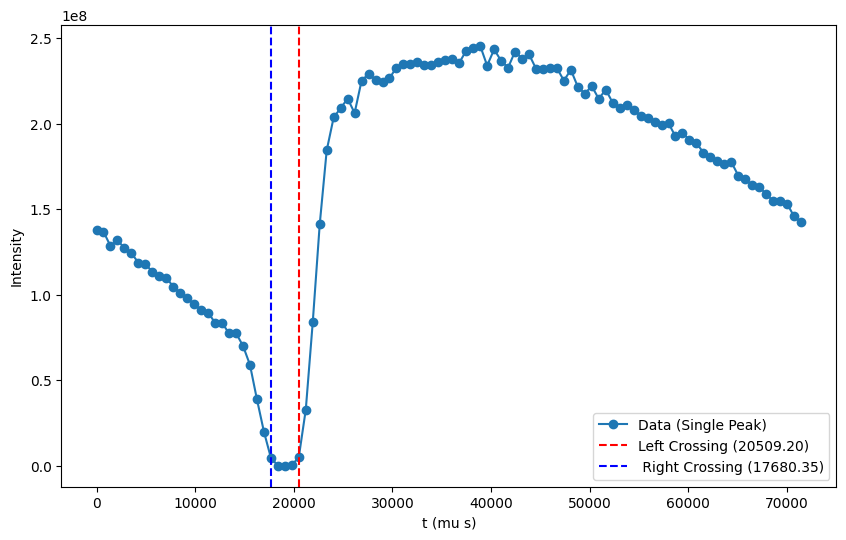

In [17]:

x=example_data.coords['t'].values
y=example_data.values

left_x, right_x, peak_x, width_x=find_threshold_crossing(y, x, threshold_fraction=0.1)
print(f"FWHM : {width_x}")
print(f"Left Crossing : {left_x}")
print(f"Right Crossing : {right_x}")
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Data (Single Peak)',marker='o')
plt.xlabel('t (mu s)')
plt.ylabel('Intensity')
plt.axvline(left_x, color='red', linestyle='--', label=f'Left Crossing ({left_x:.2f})')
plt.axvline(right_x, color='blue', linestyle='--', label=f' Right Crossing ({right_x:.2f})')
plt.legend()